In [1]:
import pickle as pkl
from pathlib import Path
from typing import Tuple

import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import mlflow
import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVR
import xgboost as xgb

from sklearn.metrics import f1_score, recall_score, precision_score

c:\Users\Aussar\.virtualenvs\mlops-zoomcamp-project-fK4v1EPx\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/raw/dermatology_database_1.csv')

TARGET = 'class'

In [3]:
data.head()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_granular_layer,vacuolisation_damage_basal_layer,spongiosis,saw_tooth_appearance_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_mononuclear_infiltrate,band_like_infiltrate,age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3


### Target distribution

Text(0.5, 1.0, 'Target distribution')

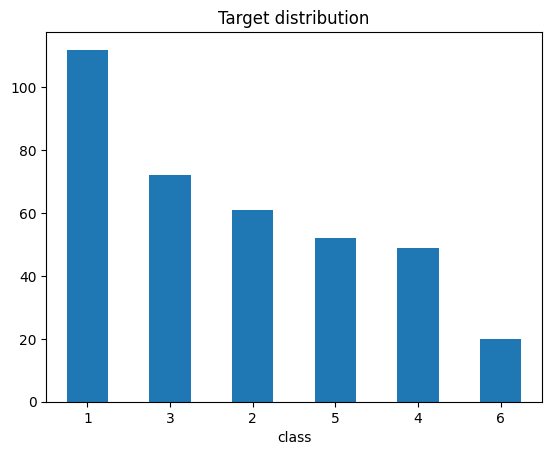

In [3]:
data["class"].value_counts().plot(kind='bar', rot=0).set_title("Target distribution")

### Data preprocessing and splits for training and evaluation

In [4]:
def transform_data(data: DataFrame) -> DataFrame:
    """Prepare data before data splits."""
    # Remove symbols 
    data = data[data['age'] != '?']
    # Convert features dtype integer to float to hanlde possible/future missing values
    data = data.astype("float64")
    # target class as integer
    data['class'] = data['class'].astype("int16")

    return data

data = transform_data(data)

In [26]:
def split_data(X, y) -> Tuple[DataFrame, DataFrame, DataFrame, Series, Series, Series]:
    """Split data in train, validation and test splits."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)
    X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1)
    
    return  X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(data.drop([TARGET], axis=1), data[TARGET])


train = pd.concat([X_train, y_train], axis=1)
val =  pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

processed_output_dir = Path("../data/processed")
processed_output_dir.mkdir(exist_ok=True, parents=True)

for split in [["train", train],
              ["val", val],
              ["test", test]]:

    split[1].to_pickle(str(processed_output_dir / f"{split[0]}.pkl"))

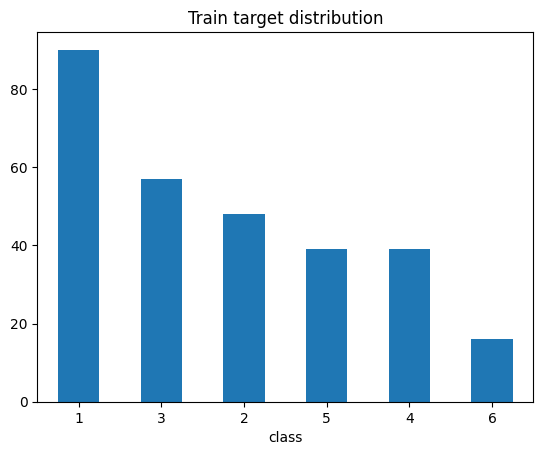

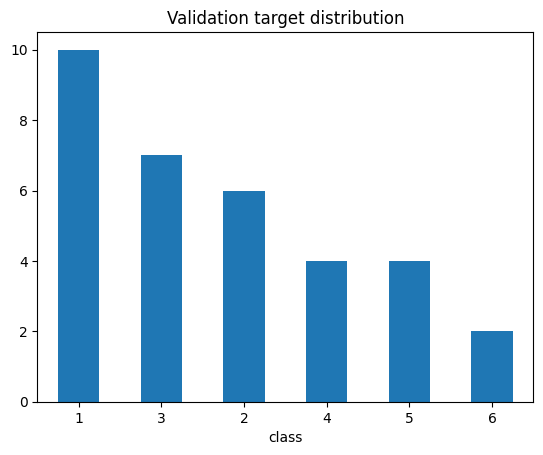

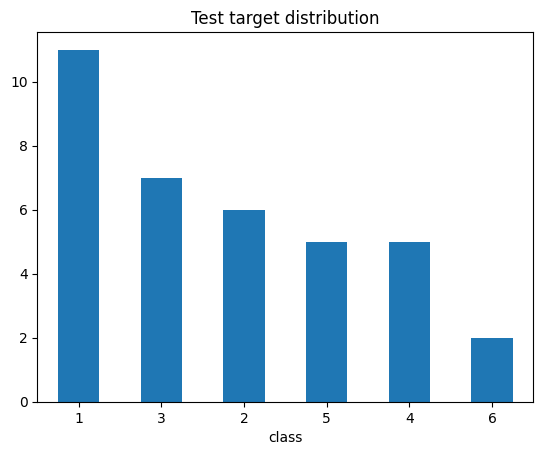

In [30]:
for split in [(y_train, "Train"), (y_val, "Validation"), (y_test, "Test")]:    
    split[0].value_counts().plot(kind='bar', rot=0).set_title(f"{split[1]} target distribution")
    plt.show()

### Model search experiments

In [32]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("dermatitis-baseline")

<Experiment: artifact_location='mlflow-artifacts:/203872331232149067', creation_time=1690039319886, experiment_id='203872331232149067', last_update_time=1690039319886, lifecycle_stage='active', name='dermatitis-baseline', tags={}>

In [43]:
mlflow.sklearn.autolog()

for model_class in (SGDClassifier, RidgeClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier):
    with mlflow.start_run(run_name=f"{model_class.__name__}_baseline"):
        mlflow.log_param("data-path", "../data/dermatology_database_1.csv")

        model = model_class()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        # 'micro': calculate metrics globally by counting the total true positives, false negatives and false positives
        f1 = f1_score(y_val, y_pred, average='micro')  
        
        mlflow.log_metric("F1", f1)
        
        print(model_class.__name__, f"F1: {round(f1, 2)}")

SGDClassifier F1: 0.94
RidgeClassifier F1: 0.94
RandomForestClassifier F1: 0.97
GradientBoostingClassifier F1: 0.94
ExtraTreesClassifier F1: 0.97


In [44]:
mlflow.xgboost.autolog()
    
with mlflow.start_run(run_name="XGBoost_baseline"):
    mlflow.log_param("data-path", "../data/dermatology_database_1.csv")
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)
    
    # setup parameters for xgboost
    params = {}
    params['booster'] = 'gbtree'
    params['objective'] = 'multi:softmax'
    params["num_class"] = 7
    params["eval_metric"] = "merror"
    params['eta'] = 0.3
    params['gamma'] = 0
    params['max_depth'] = 6
    params['min_child_weight']=1
    params['max_delta_step'] = 0
    params['subsample']= 1
    params['colsample_bytree']=1
    params['seed'] = 0
    params['base_score'] = 0.5

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50,
    )
    
    y_pred = booster.predict(valid)

    f1 = f1_score(y_val, y_pred, average='micro')
    
    mlflow.log_metric("F1", f1)
    
    print(f"XGBoost F1: {round(f1, 2)}")

[0]	validation-merror:0.06061
[1]	validation-merror:0.06061
[2]	validation-merror:0.09091
[3]	validation-merror:0.06061
[4]	validation-merror:0.06061
[5]	validation-merror:0.06061
[6]	validation-merror:0.06061
[7]	validation-merror:0.09091
[8]	validation-merror:0.09091
[9]	validation-merror:0.09091
[10]	validation-merror:0.09091
[11]	validation-merror:0.09091
[12]	validation-merror:0.09091
[13]	validation-merror:0.09091
[14]	validation-merror:0.09091
[15]	validation-merror:0.09091
[16]	validation-merror:0.09091
[17]	validation-merror:0.09091
[18]	validation-merror:0.09091
[19]	validation-merror:0.09091
[20]	validation-merror:0.09091
[21]	validation-merror:0.09091
[22]	validation-merror:0.09091
[23]	validation-merror:0.09091
[24]	validation-merror:0.09091
[25]	validation-merror:0.09091
[26]	validation-merror:0.09091
[27]	validation-merror:0.09091
[28]	validation-merror:0.09091
[29]	validation-merror:0.09091
[30]	validation-merror:0.09091
[31]	validation-merror:0.09091
[32]	validation-me

- I will select RandomForestClassifier

### Model HPO

In [51]:
def objective(trial):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 2, 100, 1),
        "max_depth" : trial.suggest_int('max_depth', 1, 20, 1),
        "min_samples_split" : trial.suggest_int('min_samples_split', 2, 10, 1),
        "min_samples_leaf" : trial.suggest_int('min_samples_leaf', 1, 10, 1),
        'random_state': 42,
        'n_jobs': -1
    }

    with mlflow.start_run(run_name=f"RandomForestClassifier_HPO"):
        mlflow.log_params(params)
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='micro')
        mlflow.log_metric("F1", f1)

    return f1

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)
    
trial = study.best_trial

print('F1: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-07-22 19:41:23,165] A new study created in memory with name: no-name-7c6b3fab-1333-4acf-a8d2-372e5de7129a
[I 2023-07-22 19:41:25,898] Trial 0 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 39, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9696969696969697.
[I 2023-07-22 19:41:28,343] Trial 1 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 17, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9696969696969697.
[I 2023-07-22 19:41:30,945] Trial 2 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 61, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9696969696969697.
[I 2023-07-22 19:41:33,748] Trial 3 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 84, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9

F1: 0.9696969696969697
Best hyperparameters: {'n_estimators': 39, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 6}
